In [86]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt 
import matplotlib.cm as cm 
import matplotlib.colors as colors 
import matplotlib.patheffects as pe 
from scipy.optimize import fsolve
from scipy.optimize import root
import scipy.spatial.distance
from scipy.spatial.distance import cdist 
from matplotlib.ticker import StrMethodFormatter
import scipy.optimize as opt 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import Locator, AutoMinorLocator, MultipleLocator
import mpltern
import sys
import argparse
import time
%matplotlib inline

In [2]:
N = 32
chi_ac = 0
chi_ab = -1
chi_bc = -10

va = 1
vb = N
vc = 1

def stab_crit (p_a, p_b, c_ab, c_bc, c_ac):
    return (1/(N*p_b) + 1/(1-p_a - p_b) - 2 * c_bc) * (1/p_a + 1/(1-p_a - p_b) - 2 * c_ac) - (1/(1-p_a-p_b) + c_ab - c_bc - c_ac) ** 2

# FIND PHI_B GIVEN PHI_A
mu_a = lambda phi_a, phi_b: np.log(phi_a)         + 1 - phi_a - va/vb * phi_b - va/vc * (1-phi_a-phi_b) + va * (phi_b**2 * chi_ab + (1-phi_a-phi_b)**2 * chi_ac + phi_b * (1-phi_a-phi_b) * (chi_ab + chi_ac - chi_bc) ) 
mu_b = lambda phi_a, phi_b: np.log(phi_b)         + 1 - phi_b - vb/va * phi_a - vb/vc * (1-phi_a-phi_b) + vb * (phi_a**2 * chi_ab + (1-phi_a-phi_b)**2 * chi_bc + phi_a * (1-phi_a-phi_b) * (chi_ab + chi_bc - chi_ac) )
mu_c = lambda phi_a, phi_b: np.log(1-phi_a-phi_b) + 1 - (1-phi_a-phi_b) - vc/va * phi_a - vc/vb * phi_b + vc * (phi_a**2 * chi_ac + phi_b**2 * chi_bc + phi_a * phi_b * (chi_ac + chi_bc - chi_ab) )


Text(0.5, 0, 'Vol. frac. C')

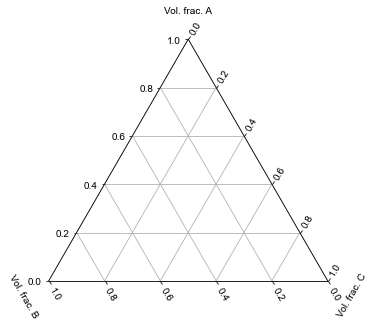

In [78]:
start = time.time()
lsize = 3
plt.rcParams['font.family'] = 'Arial'
font = {'color':  'black',
    'weight': 'normal',
    'size': lsize}

fig = plt.figure(num=1, figsize=(5,5))
ax  = fig.add_subplot (projection="ternary")    
ax.grid ()
positions = ['tick1', 'tick2']
for position in positions:
    ax.taxis.set_ticks_position(position)
    ax.laxis.set_ticks_position(position)
    ax.raxis.set_ticks_position(position)

ax.set_tlabel('Vol. frac. A')
ax.set_llabel('Vol. frac. B')
ax.set_rlabel('Vol. frac. C')

In [138]:
fix_b = 1e-4
def mu_eq (phi):
    eq1 = mu_a(phi[0], fix_b) - mu_a(phi[1], phi[2])
    eq2 = mu_b(phi[0], fix_b) - mu_b(phi[1], phi[2])
    eq3 = mu_c(phi[0], fix_b) - mu_c(phi[1], phi[2])
    
    return [eq1, eq2, eq3]

In [139]:
root = fsolve (mu_eq, [0.99, 0.2, 0.1])
print(f"delta mu = {mu_eq(root)}")
print(root)


delta mu = [0.8826183515805986, 162.5108295210179, -4.076214802902859]
[0.99 0.2  0.1 ]


/var/folders/gn/nzb5h_193xs6scmlhvpn67txypqxcp/T/ipykernel_37186/1437694451.py:14: RuntimeWarning: invalid value encountered in log
  mu_a = lambda phi_a, phi_b: np.log(phi_a)         + 1 - phi_a - va/vb * phi_b - va/vc * (1-phi_a-phi_b) + va * (phi_b**2 * chi_ab + (1-phi_a-phi_b)**2 * chi_ac + phi_b * (1-phi_a-phi_b) * (chi_ab + chi_ac - chi_bc) )


In [129]:
ax.scatter (root[0], fix_b, 1-fix_b-root[0])
ax.scatter (root[1], root[2], 1-root[2]-root[1])
fig.savefig("test")

In [33]:
stab_crit(root[1], root[2], chi_ab, chi_bc, chi_ac)

73.3125257045181

In [ ]:
# seed that worked for phi_b1=1e-6, phi_a1=0.999, phi_a2=0.18, phi_b2=0.55

In [3]:
# generate a fine mesh 
mesh  = 500
phi_b = np.linspace (0.00001, 0.6, mesh)
phi_b = np.repeat (phi_b, mesh)
phi_a = np.zeros  (phi_b.shape)
for i in range (mesh):
    upper_lim = 0.999 if phi_b[i*mesh] < 0.001 else 1-phi_b[i*mesh] - 0.001
    phi_a[i*mesh:(i+1)*mesh] = np.linspace (0.001, upper_lim, mesh)

In [4]:
to_keep = stab_crit (phi_a, phi_b, chi_ab, chi_bc, chi_ac) > 0
phi_b   = phi_b [to_keep]
phi_a   = phi_a [to_keep]

In [5]:
print (np.sum(to_keep))

158861


In [6]:
phis       = np.array([phi_a, phi_b, 1-phi_a-phi_b]).T
chem_pot_a = mu_a (phi_a, phi_b)
chem_pot_b = mu_b (phi_a, phi_b)
chem_pot_c = mu_c (phi_a, phi_b)
mu         = np.array ([chem_pot_a, chem_pot_b, chem_pot_c]).T

In [7]:
# problem section as meshsize goes up
# start = time.time()
# phi_dists = np.linalg.norm(phis[np.newaxis,:,:]-phis[:,np.newaxis,:],axis=-1)
# mu_dists  = np.linalg.norm(mu[np.newaxis,:,:]-mu[:,np.newaxis,:], axis=-1)
# stop = time.time()
# print (f"Elapsed time is {stop-start} seconds.")

In [8]:
print(mu.shape)
print(phis.shape)

(158861, 3)
(158861, 3)


In [9]:
start = time.time()
block_size = 1000
block_num  = np.sum(to_keep) // block_size + 1

phi_big_block  = phis[np.newaxis,:,:]
phi_dists      = np.zeros ((np.sum(to_keep), np.sum(to_keep)))

mu_big_block   = mu[np.newaxis,:,:]
mu_dists       = np.zeros ((np.sum(to_keep), np.sum(to_keep)))

for i in range (block_num):
    print (f"On i = {i}...")
    if i < block_num - 1:
        phi_dists[i*block_size:(i+1)*block_size,:] = np.linalg.norm(phi_big_block - phis[i*block_size:(i+1)*block_size,np.newaxis,:],     axis=-1)
        mu_dists [i*block_size:(i+1)*block_size,:] = np.linalg.norm(mu_big_block  - mu[i*block_size:(i+1)*block_size,np.newaxis,:], axis=-1)
        
    else:
        phi_dists[i*block_size:,:] = np.linalg.norm(phi_big_block-phis[i*block_size:,np.newaxis,:]      , axis=-1)
        mu_dists [i*block_size:,:] = np.linalg.norm(mu_big_block  - mu[i*block_size:,np.newaxis,:], axis=-1)

print ("Done!")
stop = time.time()
print (f"Elapsed time is {stop-start} seconds.")


On i = 0...
On i = 1...
On i = 2...
On i = 3...
On i = 4...


KeyboardInterrupt: 

In [ ]:
mask = dists > 0.1 
phi_dists = np.where (mask, phi_dists, np.inf)
mu_dists  = np.where (mask, mu_dists , np.inf)